# Balanced - with age-groups
Introducing age-groups to balance the dataset and to make prediction easier, because we will only attempt to predict the age-group, not the precise age.

## Load Data afresh

In [12]:
import pandas as pd
import numpy as np
from pathlib import Path

columns = ["Sex", "Length", "Diameter", "Height", "Whole", "Shucked", "Viscera", "Shell", "Rings"]
sourcepath = Path(r"Data\abalone.data".replace("\\", "/"))
data = pd.read_csv(sourcepath, names=columns)

data.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Data Preparation

One-hot encode the categorical variable "Sex"

In [13]:
data = pd.get_dummies(data, columns=["Sex"], prefix=['sex_'], dtype=float)
data.head()

,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings,sex__F,sex__I,sex__M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.0,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.0,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1.0,0.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.0,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.0,1.0,0.0


In [14]:
# grouping data
young_age = 8
old_age = 11
medium_low_age = young_age + 1
medium_upper_age = old_age - 1

data["age_group"] = 0

for idx in data.index:
    row = data.loc[idx]
    #print(row.Rings)
    if row.Rings <= young_age:
        #print("young")
        data.loc[idx, "age_group"] = 1
    elif row.Rings >= old_age:
        #print("old")
        data.loc[idx, "age_group"] = 3
    elif row.Rings >= medium_low_age and row.Rings <= medium_upper_age :
        #print("medium")
        data.loc[idx, "age_group"] = 2


In [15]:
data = data.drop(["Rings"], axis=1)
data.head()

,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,sex__F,sex__I,sex__M,age_group
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.0,0.0,1.0,3
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.0,0.0,1.0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1.0,0.0,0.0,2
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.0,0.0,1.0,2
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.0,1.0,0.0,1


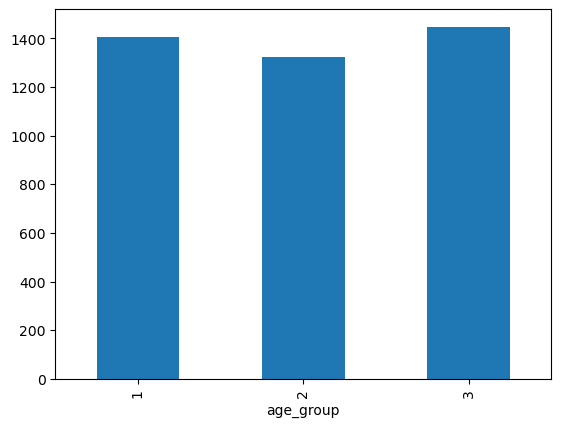

In [16]:
age_groups = data.groupby(["age_group"])["age_group"].count()
ax_age_groups = age_groups.plot(kind="bar")

Our age-groups are balanced now.

In [17]:
X_train = data.to_numpy()[:,:-1]
y_train = data.to_numpy()[:,-1]


X_train.shape, y_train.shape

((4177, 10), (4177,))

## Spot-Shooting on Balanced and Binned Data

### Train and Evaluate

In [18]:
from sklearn.metrics import make_scorer, matthews_corrcoef

matthews_cc_scorer = make_scorer(matthews_corrcoef)

In [21]:
# with crossvalidation

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

models_accuracies = {}
validation_folds = 10

print(f"--- Using Classifiers with {validation_folds}-fold Cross-Validation ---")

classifiers = {
    "logistic_reg" : LogisticRegression(solver="sag", max_iter=100, random_state=42, multi_class="multinomial"), # pre-defined parameters to avoid some warnings
    "decision_tree_clf" : DecisionTreeClassifier(),
    "support_vec_clf" : SVC(),
    "random_forrest_clf" : RandomForestClassifier(),
    "gradient_boosting_clf" : GradientBoostingClassifier(),
    "k_NN_clf" : KNeighborsClassifier(),
    "naive_bayes_clf" : GaussianNB(),
    "neural_network_clf" : MLPClassifier()
}

X_train = StandardScaler().fit_transform(X_train)

for clf_name, clf_instance in classifiers.items():
    #models_accuracies[clf_name] = cross_val_score(clf_instance, X_train, y_train, scoring= "accuracy", cv = validation_folds, n_jobs=-1)
    models_accuracies[clf_name] = cross_val_score(clf_instance, X_train, y_train, scoring= matthews_cc_scorer, cv = validation_folds, n_jobs=-1)

print(f"--- Accuracies with {validation_folds}-fold cross-validation: ---")
print("| Model-Name | Mean Accuracy | Standard Deviation|")
print("|--------|--------|------|")
for name, acc in models_accuracies.items():
    print(f"| {name:22} | {acc.mean():4.2f} | {acc.std():4.2f} |")

--- Using Classifiers with 10-fold Cross-Validation ---
--- Accuracies with 10-fold cross-validation: ---
| Model-Name | Mean Accuracy | Standard Deviation|
|--------|--------|------|
| logistic_reg           | 0.47 | 0.04 |
| decision_tree_clf      | 0.34 | 0.04 |
| support_vec_clf        | 0.48 | 0.03 |
| random_forrest_clf     | 0.45 | 0.04 |
| gradient_boosting_clf  | 0.46 | 0.04 |
| k_NN_clf               | 0.41 | 0.04 |
| naive_bayes_clf        | 0.35 | 0.10 |
| neural_network_clf     | 0.49 | 0.04 |


--- Using Classifiers with 10-fold Cross-Validation ---
--- Accuracies with 10-fold cross-validation: ---
| Model-Name | Mean Accuracy | Standard Deviation|
|--------|--------|------|
| logistic_reg           | 0.64 | 0.03 |
| decision_tree_clf      | 0.56 | 0.02 |
| support_vec_clf        | 0.65 | 0.02 |
| random_forrest_clf     | 0.63 | 0.03 |
| gradient_boosting_clf  | 0.64 | 0.03 |
| k_NN_clf               | 0.60 | 0.03 |
| naive_bayes_clf        | 0.57 | 0.07 |
| neural_network_clf     | 0.66 | 0.03 |

--- Using Classifiers with 10-fold Cross-Validation ---
--- MCC with 10-fold cross-validation: ---
| Model-Name | Mean MCC | Standard Deviation|
|--------|--------|------|
| logistic_reg           | 0.47 | 0.04 |
| decision_tree_clf      | 0.34 | 0.04 |
| support_vec_clf        | 0.48 | 0.03 |
| random_forrest_clf     | 0.45 | 0.04 |
| gradient_boosting_clf  | 0.46 | 0.04 |
| k_NN_clf               | 0.41 | 0.04 |
| naive_bayes_clf        | 0.35 | 0.10 |
| neural_network_clf     | 0.49 | 0.04 |